In [38]:
# import libraries
import math
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import time

import plotly.graph_objects as go

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [2]:
def bulirsch_stoer_3d(position, velocity, timestep, Fx, Fy, Fz, args_x, args_y, args_z, N, h, q, p):
    # position = (x_n, y_n, z_n): the x, y and z position at time n
    # velocity = (Vx_n, Vy_n, Vz_n): the velocity vector components for x, y and z at time n
    # timestep: delta(t), interval of time between 2 approximations
    # F_x: the derivative function for x component of velocity
    # F_y: the derivation function for y component of velocity
    # F_z: the derivation function for z component of velocity
    # args_x: arguments to be passed to F_x (in addition to Vx, Vy, Vz, x, y, z)
    # args_y: arguments to be passed to F_y (in addition to Vx, Vy, Vz, x, y, z)
    # args_z: arguments to be passed to F_z (in addition to Vx, Vy, Vz, x, y, z)
    # N: number of steps for the modified midpoint method so that h = step_size = timestep/N
    # h: first step size to try for the midpoint method 
    # q: such that h/q is other step size to try for the midpoint method
    # p: for Richardson extrapolation, if p = 1: linear ...
    
    # step 1: modified midpoint method with step size h
    x_values1, y_values1, z_values1, Vx_values1, Vy_values1, Vz_values1 = modified_midpoint_method(position, velocity, Fx, Fy, Fz, args_x, args_y, args_z, N, h)
    
    # step 2: modified midpoint method with step size h/q
    N_2 = int((timestep * q)/h)
    h_2 = h/q
    
    x_values2, y_values2, z_values2, Vx_values2, Vy_values2, Vz_values2 = modified_midpoint_method(position, velocity, Fx, Fy, Fz, args_x, args_y, args_z, N_2, h_2)
    
    # step 3: Richardson Extrapolation
    x_final = Richardson_extrapolation(x_values1, x_values2, q, p)
    y_final = Richardson_extrapolation(y_values1, y_values2, q, p)
    z_final = Richardson_extrapolation(z_values1, z_values2, q, p)
    
    Vx_final = Richardson_extrapolation(Vx_values1, Vx_values2, q, p)
    Vy_final = Richardson_extrapolation(Vy_values1, Vy_values2, q, p)
    Vz_final = Richardson_extrapolation(Vz_values1, Vz_values2, q, p)
    
    return (x_final, y_final, z_final), (Vx_final, Vy_final, Vz_final)

def Richardson_extrapolation(f_h, f_hq, q, p):
    return f_h + (f_h - f_hq)/((q**(-p)) -1)

def modified_midpoint_method(position, velocity, Fx, Fy, Fz, args_x, args_y, args_z, N, h):
    x_values = []
    y_values = []
    z_values = []
    
    Vx_values = []
    Vy_values = []
    Vz_values = []
    
    Fx_values = []
    Fy_values = []
    Fz_values = []
    
    # prep
    x_values.append(position[0])
    y_values.append(position[1])
    z_values.append(position[2])
    
    Vx_values.append(velocity[0])
    Vy_values.append(velocity[1])
    Vz_values.append(velocity[2])
    
    Fx_values.append(Fx(args_x, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0]))
    Fy_values.append(Fy(args_y, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0]))
    Fz_values.append(Fz(args_z, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0]))
    
    # step 1
    # print("step:", 1)
    x_values.append(x_values[0] + Vx_values[0] * h)
    y_values.append(y_values[0] + Vy_values[0] * h)
    z_values.append(z_values[0] + Vz_values[0] * h)

    Vx_values.append(Vx_values[0] + Fx_values[0] * h)
    Vy_values.append(Vy_values[0] + Fy_values[0] * h)
    Vz_values.append(Vz_values[0] + Fz_values[0] * h)

    Fx_values.append(Fx(args_x, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1]))
    Fy_values.append(Fy(args_y, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1]))
    Fz_values.append(Fz(args_z, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1]))

    # steps 2 +
    for n in range(2, N+1):
        # print("step:", n)
        x_values.append(x_values[n-2] + Vx_values[n-1] * 2 * h)
        y_values.append(y_values[n-2] + Vy_values[n-1] * 2 * h)
        z_values.append(z_values[n-2] + Vz_values[n-1] * 2 * h)

        Vx_values.append(Vx_values[n-2] + Fx_values[n-1] * 2 * h)
        Vy_values.append(Vy_values[n-2] + Fy_values[n-1] * 2 * h)
        Vz_values.append(Vz_values[n-2] + Fz_values[n-1] * 2 * h)

        Fx_values.append(Fx(args_x, Vx_values[n], Vy_values[n], Vz_values[n], x_values[n], y_values[n], z_values[n]))
        Fy_values.append(Fy(args_y, Vx_values[n], Vy_values[n], Vz_values[n], x_values[n], y_values[n], z_values[n]))
        Fz_values.append(Fz(args_z, Vx_values[n], Vy_values[n], Vz_values[n], x_values[n], y_values[n], z_values[n]))
    
    # final step
    x_values = 1/2 * (x_values[N] + x_values[N-1] + (h * Vx_values[N]))
    y_values = 1/2 * (y_values[N] + y_values[N-1] + (h * Vy_values[N]))
    z_values = 1/2 * (z_values[N] + z_values[N-1] + (h * Vz_values[N]))

    Vx_values = 1/2 * (Vx_values[N] + Vx_values[N-1] + (h * Fx_values[N]))
    Vy_values = 1/2 * (Vy_values[N] + Vy_values[N-1] + (h * Fy_values[N]))
    Vz_values = 1/2 * (Vz_values[N] + Vz_values[N-1] + (h * Fz_values[N]))
    
    return x_values, y_values, z_values, Vx_values, Vy_values, Vz_values


In [3]:
def gravitational_force(args, Vx, Vy, Vz, x, y, z):
    n = args[0] # position of body in array of all bodies
    m = args[1] # mass array
    component = args[2] # "x", "y", or "z"
    x_all = args[3] # last x position of all bodies (array)
    y_all = args[4] # last x position of all bodies (array)
    z_all = args[5] # last x position of all bodies (array)
    G_or_const = args[6]
    
    F = 0

    for body in range(len(x_all)):
        if body != n:
            # claculate distance between 2 bodies
            r =  math.sqrt((x_all[body] - x)**2 + (y_all[body] - y)**2 + (z_all[body] - z)**2)
            # print("r:", r)
            if component == "x":
                F -= G_or_const * m[body] * ((x - x_all[body])/r**3)
            elif component == "y":
                F -= G_or_const * m[body] * ((y - y_all[body])/r**3)
            elif component == "z":
                F -= G_or_const * m[body] * ((z - z_all[body])/r**3)      
    return F

In [4]:
# universal gravitation constant
G = 6.67259e-20  # (km**3/kg/s**2)

input_file = "bodies2.csv"
output_trajectories = "blender/trajectories_step2.csv"
output_body_properties = "blender/body_properties2.csv"

In [5]:
df = pd.read_csv(input_file)
bodies = list(df['body'])
print(bodies)
df = df.set_index('body')
display(df)

n_bodies = len(df)
print(n_bodies)

['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


9


In [6]:
# non-dimentionalize code
# universal gravitation constant
G = 6.67259e-20  # (km**3/kg/s**2)
mass_sun = 1.989e30 # kg
AU = 1.496e8 #km
year = 3.156e7 #s
norm_const = (G * mass_sun * (year**2))/(AU**3)
print(norm_const)

# set array of masses and normalize
m = list(df["mass"])
m = [i/mass_sun for i in m]
print(m)

39.482844360900664
[1.000050276520865, 3.002513826043238e-06, 0.0009547511312217195, 0.0002857214680744092, 5.1483157365510307e-05, 4.364504776269483e-05, 2.4469582704876823e-06, 3.2257415786827553e-07, 1.65158371040724e-07]


In [41]:
# initial conditions: store in arrays
# NASA JBL 01/01/2023 for eath and sun (vector table)
# observer: solar system barycenter 

x = []
y = []
z = []

Vx = []
Vy = []
Vz = []

# NORMALIZE POSITIONS AND VELOCITIES TOO
for n in range(n_bodies):
    row = df.loc[bodies[n]]
    # print(row)
    x.append([row.x/AU])
    y.append([row.y/AU])
    z.append([row.z/AU])
    
    Vx.append([row.Vx*(year/AU)])
    Vy.append([row.Vy*(year/AU)])
    Vz.append([row.Vz*(year/AU)])
    
print("x:", x)
print("y:", y)
print("z:", z)
print("Vx:", Vx)
print("Vy:", Vy)
print("Vz:", Vz)

x: [[-0.009055016159966617], [-0.1793085625550183], [4.8291006685631475], [8.138215814399752], [29.75138566404254], [13.360498481186276], [0.5521040013798607], [0.051822082348051066], [0.11791618807725736]]
y: [[9.495630345800982e-05], [0.9685666471737507], [1.0453167199420428], [-5.504951619894438], [-2.9426746516096243], [14.426954287758068], [-0.46228718968658006], [1.562825907716532], [0.28112208900729396]]
z: [[0.00021015644618283588], [0.00016129686599527607], [-0.11237663331179339], [-0.2283016941828624], [-0.6250519716101802], [-0.11950533649100502], [-0.03851799114077272], [0.03146889384815788], [0.01152924029751236]]
Vx: [[0.00034519862016138184], [6.289811699774153], [-0.6145791407882866], [1.0279713308219738], [0.10534561718523733], [-1.0645635001897862], [4.651622703561451], [-4.9136727136113825], [-11.41965988591572]]
Vy: [[-0.0032874007978930778], [-1.1172406489022908], [2.8234895926957453], [1.683921697068667], [1.1479311005631836], [0.9092226448443977], [5.670265031639

In [42]:
n_days_timestep = 2
n_days_total = 365 * 165 # number of days I want to simulate
n_timesteps = int(n_days_total/n_days_timestep) # number of timesteps
print("Number of timesteps:", n_timesteps)

timestep = (86400/year) * n_days_timestep # (86400/year) = 1 day in non dimensional
print("Timestep:", timestep)

# variables for Bulirsch-Stoer method
N = 4
h = timestep/N
print(N)
print(h)
q = 2
p = 1

Number of timesteps: 30112
Timestep: 0.005475285171102661
4
0.0013688212927756654


In [43]:
start_time = time.time()
for t in range(n_timesteps):
#     if t%(500) == 0:
#         print(int(t/500))
    # set array with latest position for all bodies
    x_last_all = []
    y_last_all = []
    z_last_all = []
    for n in range(n_bodies):
        x_last_all.append(x[n][-1])
        y_last_all.append(y[n][-1])
        z_last_all.append(z[n][-1])
    
    for n in range(n_bodies):
        # for a specific body: p_components are its position, c_components are its velocity components
        p_components = (x_last_all[n], y_last_all[n], z_last_all[n])
        v_components = (Vx[n][-1], Vy[n][-1], Vz[n][-1])
        
        args_x = (n, m, "x", x_last_all, y_last_all, z_last_all, norm_const)
        args_y = (n, m, "y", x_last_all, y_last_all, z_last_all, norm_const)
        args_z = (n, m, "z", x_last_all, y_last_all, z_last_all, norm_const)
        
        p_components, v_components = bulirsch_stoer_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)
        
        # add new value in arrays
        x[n].append(p_components[0])
        y[n].append(p_components[1])
        z[n].append(p_components[2])
        
        Vx[n].append(v_components[0])
        Vy[n].append(v_components[1])
        Vz[n].append(v_components[2])
        
print(time.time() - start_time)


113.34042406082153


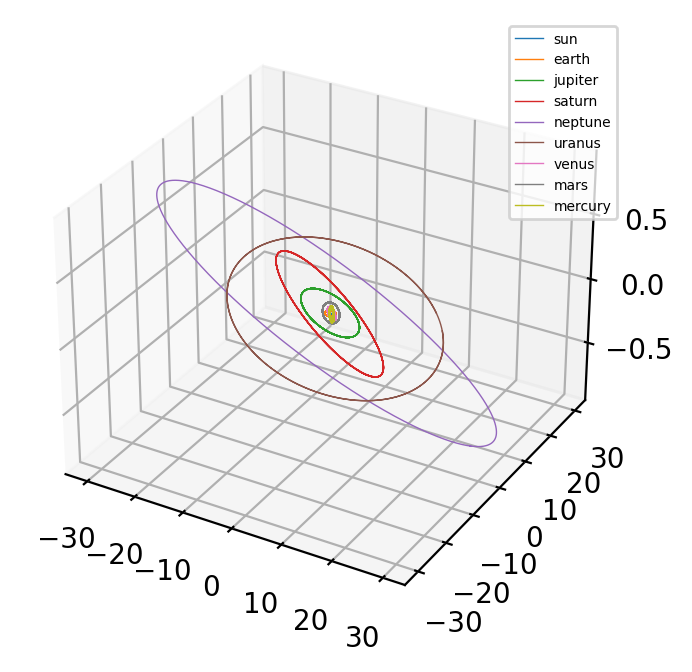

In [32]:
ax = plt.figure(dpi = 200).add_subplot(projection='3d')
# ax.set_aspect('equal')
for i in range(n_bodies):
    ax.plot(x[i], y[i], z[i], label = bodies[i], linewidth = 0.5)
# ax.set_zlim(0.0001, 0.0003)
ax.legend(fontsize="5")
# plt.savefig("plot_bulirsch_stoer.png")
# plt.savefig("earth_trajectory/earth_trajectory_%i_body_system_multiple_orbits.png"%(n_bodies))
plt.show()

In [37]:
print(len(Vx[0]))

30113
